In [21]:
# CELL 1 — Turn on the tools we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

print("Tools are ready!")

Tools are ready!


In [31]:
# CELL 2 — Open your BTC data file
# Change the file path to where your CSV is saved
data = pd.read_csv('/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/data/processed/crypto_labeled_data.csv')

# Make sure the dates go from old to new
data = data.sort_values("open_time").reset_index(drop=True)

print(f"We have {len(data)} days of Bitcoin data")
print(f"From {data['open_time'].iloc[0]} to {data['open_time'].iloc[-1]}")
data.info()

We have 801 days of Bitcoin data
From 2023-09-12 to 2025-11-20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   open_time              801 non-null    object 
 1   open                   801 non-null    float64
 2   high                   801 non-null    float64
 3   low                    801 non-null    float64
 4   close                  801 non-null    float64
 5   volume                 801 non-null    float64
 6   close_time             801 non-null    object 
 7   quote_asset_volume     801 non-null    float64
 8   num_trades             801 non-null    int64  
 9   taker_base_volume      801 non-null    float64
 10  taker_quote_volume     801 non-null    float64
 11  1_day_return           801 non-null    float64
 12  7_day_return           801 non-null    float64
 13  7_day_volatility       801 non-null    float64


Test Accuracy: 0.44
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.32      0.17        19
           1       0.76      0.50      0.60        90
           2       0.18      0.17      0.17        12

    accuracy                           0.44       121
   macro avg       0.35      0.33      0.32       121
weighted avg       0.60      0.44      0.49       121



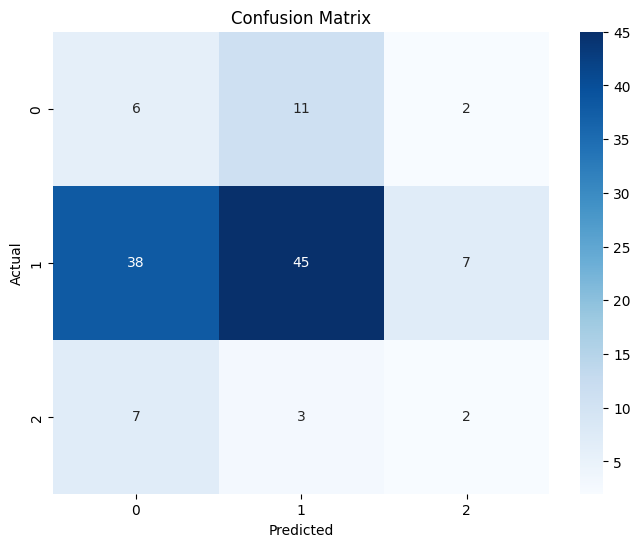

In [36]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import joblib

def prepare_splits(data):
    """
    Prepares X, y and splits chronologically.
    """
    # Features (exclude dates, labels, raw OHLC to avoid leakage)
    features = ['1_day_return', '7_day_return', '7_day_volatility', 'rsi', 'macd',
                'sma20', 'sma50', 'sma200', 'bb_high', 'bb_low', 'stochastic_oscillator',
                'volume', 'num_trades']
    X = data[features]
    y = data['label']

    # Chronological split
    train_size = int(0.7 * len(data))
    val_size = int(0.15 * len(data))
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def train_model(X_train, y_train, X_val, y_val):
    """
    Trains LightGBM classifier.
    """
    model = LGBMClassifier(
        objective='multiclass',
        num_class=3,
        metric='multi_logloss',
        learning_rate=0.05,
        num_leaves=31,
        random_state=42
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='multi_logloss')
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluates on test set.
    """
    #y_pred = model.predict(X_test)
    #acc = accuracy_score(y_test, y_pred)
    #f1 = f1_score(y_test, y_pred, average='macro')
    #cm = confusion_matrix(y_test, y_pred)
    #print(f"Accuracy: {acc:.2f}")
    #print(f"Macro F1: {f1:.2f}")
    #print("Confusion Matrix:\n", cm)

y_pred = model.predict(X_test)  
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Main
if __name__ == "__main__":
    df_labeled = pd.read_csv('/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/data/processed/crypto_labeled_data.csv')
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_splits(df_labeled)
    
    model = train_model(X_train, y_train, X_val, y_val)
    evaluate_model(model, X_test, y_test)
    
    # Serialize
    #joblib.dump(model, 'models/buy_sell_classifier.pkl')
   # print("Model saved!")